# 1. Time Series with Sliding Window

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [80]:
df = pd.read_csv('All Stocks.csv')
df.index = df['Date']
col_names = list(df.columns)
df.head()

,Date,IBM_Monthly_Return,LNR.TO_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return
Date,,,,,,
01/10/2021,01/10/2021,-9.95%,3.50%,7.02%,8.05%,-0.70%
01/09/2021,01/09/2021,-1.00%,-7.99%,-4.65%,-4.65%,-9.82%
01/08/2021,01/08/2021,0.72%,-2.95%,2.98%,-5.36%,-5.56%
01/07/2021,01/07/2021,-3.84%,-5.05%,2.44%,-9.51%,5.93%
01/06/2021,01/06/2021,1.98%,-2.93%,2.24%,-7.90%,-10.47%


In [81]:
# change date to date and time
df['Date'] = pd.to_datetime(df.Date,format='%d/%m/%Y')
# change montly return to float
df["LNR.TO_Monthly_Return"] = df["LNR.TO_Monthly_Return"].str.replace(r'.%$', '')
df["LNR.TO_Monthly_Return"] = pd.to_numeric(df["LNR.TO_Monthly_Return"])
print(df.dtypes)
# reverse the df frame to have the oldest data at the start
df = df.reindex(index=df.index[::-1])
df.head()

Date                     datetime64[ns]
IBM_Monthly_Return               object
LNR.TO_Monthly_Return           float64
SPY_Monthly_Return               object
MGA_Monthly_Return               object
ABX.TO_Monthly_Return            object
dtype: object


,Date,IBM_Monthly_Return,LNR.TO_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return
Date,,,,,,
01/10/2001,2001-10-01,17.83%,-27.3,1.30%,0.27%,-10.29%
01/11/2001,2001-11-01,7.09%,17.5,7.80%,19.95%,-4.04%
01/12/2001,2001-12-01,4.65%,11.0,0.56%,0.59%,7.16%
01/01/2002,2002-01-01,-10.81%,3.8,-0.98%,2.33%,7.27%
01/02/2002,2002-02-01,-8.93%,-16.0,-1.79%,6.64%,5.49%


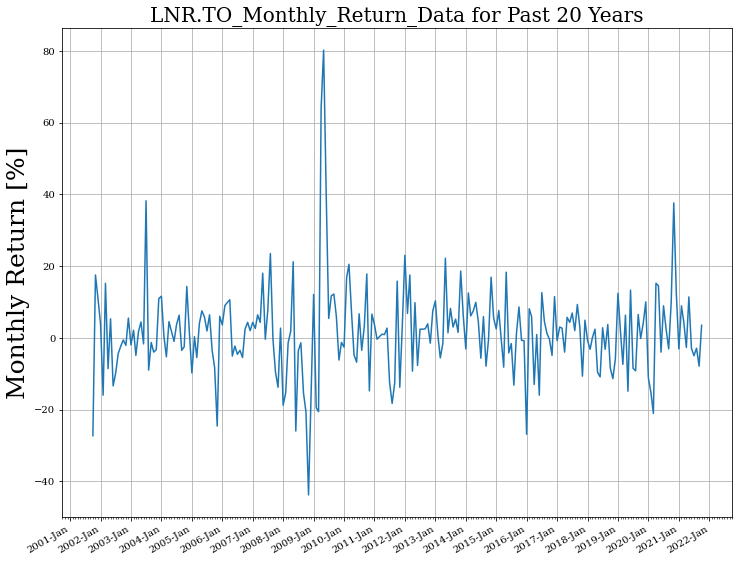

In [135]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
# plt.rcParams["font.family"] = "Times New Roman"
# csfont = {'fontname':'Times New Roman'}
# Reference for how to adjust the matplot settings:
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html

stock_name = "LNR.TO"
col_name = stock_name+"_Monthly_Return"

x = df["Date"]
y = df["LNR.TO_Monthly_Return"]
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Monthly Return [%]',fontsize=25)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.title(col_name+"_Data for Past 20 Years",fontsize=20)
# ax.set_title(col_name+"_Data for Past 20 Years", loc='left', y=0.95, x=0.02,
#              fontsize=20)
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

In [84]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', col_name])
# make a deep copy of the dataset, and sort by date
for i in range(0,len(df)):
     new_data['Date'][i] = df['Date'][i]
     new_data[col_name][i] = df[col_name][i]
full_training_size = len(new_data)*8//10 # 192
validation_size = full_training_size*2//10 # 38 for validation
training_size = full_training_size-validation_size # 154 for train
testing_size = len(new_data)-full_training_size # 49 for testing
print("The input is split into {} for training, {} for validation, and {} for testing".format(training_size, validation_size, testing_size))

The input is split into 154 for training, 38 for validation, and 49 for testing


In [137]:
# splitting into train and testing, 80% for training, 20% for testing
train = new_data[:training_size]
valid = new_data[training_size:training_size+validation_size]
test = new_data[-testing_size:]
full_train = new_data[:full_training_size] # train + validate

# make prediction by using the past 5 years data
# in a rolling windows base
preds = []
num_of_month_to_lookback = 12
for i in range(0,valid.shape[0]):
    a = train[col_name][len(train)-num_of_month_to_lookback+i:].sum() + sum(preds)
    b = a/num_of_month_to_lookback
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid[col_name])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
17.006186172876788


Try to find the best sliding window size

In [157]:
# given a slid window size, and a training dataset (include all the data, train and test), and a testing data,
# return the RMSE error
def calculate_RMSE_from_sliding_window_size(slid_window_size,training,testing):
  num_of_month_to_lookback = slid_window_size
  preds = []
  training_end_index = len(training)-len(testing)
  for i in range(0,len(testing)):
    # print("start with",str(training_end_index+i-num_of_month_to_lookback),"end at ",str(training_end_index+i) )
    sliding_window_average = (training[col_name][training_end_index+i-num_of_month_to_lookback:training_end_index+i].sum())/num_of_month_to_lookback
    preds.append(sliding_window_average)
  RMSE=np.sqrt(np.mean(np.power((np.array(testing[col_name])-preds),2)))
  return RMSE

# return a list of predict value based on a given slid window size
def calculate_RMSE_list_from_sliding_window_size(slid_window_size,training,testing):
  num_of_month_to_lookback = slid_window_size
  preds = []
  training_end_index = len(training)-len(testing)
  for i in range(0,len(testing)):
    # print("start with",str(training_end_index+i-num_of_month_to_lookback),"end at ",str(training_end_index+i) )
    sliding_window_average = (training[col_name][training_end_index+i-num_of_month_to_lookback:training_end_index+i].sum())/num_of_month_to_lookback
    preds.append(sliding_window_average)
  RMSE=np.sqrt(np.mean(np.power((np.array(testing[col_name])-preds),2)))
  print("the RMSE of this model on the testing set is:",str(RMSE))
  return preds


result = calculate_RMSE_from_sliding_window_size(5,full_train,valid)
print(result)


9.011509599570868


we find out that 10 is the best slide window size based on the validation data

8.971132211593737


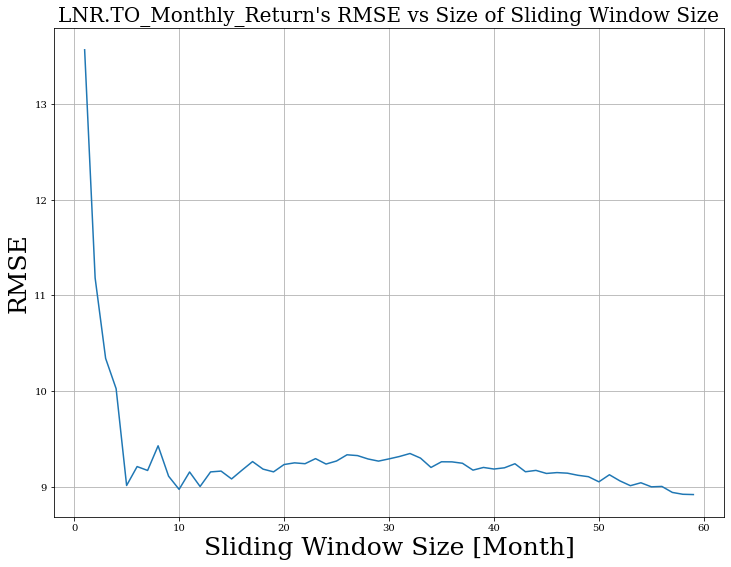

In [155]:
x = [_ for _ in range(1,60)]
y = []
for i in x:
  y.append(calculate_RMSE_from_sliding_window_size(i,full_train,valid))
tick_spacing = 350
# change the default font family
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_ylabel(r'RMSE',fontsize=25)
ax.set_xlabel(r'Sliding Window Size [Month]',fontsize=25)
plt.title(col_name+"'s RMSE vs Size of Sliding Window Size",fontsize=20)
ax.plot(x,y)
print(y[9])

Plot a train, validation and test and prediciton data

In [158]:
#plot
plt.figure(figsize=(12,9))
predicted_validation_result = calculate_RMSE_list_from_sliding_window_size(10, full_train, valid)
predicted_test_result = calculate_RMSE_list_from_sliding_window_size(10, new_data, test)

valid.loc[:,"Predictions"]=predicted_validation_result
test.loc[:,"Predictions"]=predicted_test_result
a = valid[[col_name, 'Predictions']]  # print two column
test.head()

# set index as date
full_train.index = full_train['Date']
valid.index = valid['Date']
test.index = test['Date']


the RMSE of this model on the testing set is: 8.971132211593737
the RMSE of this model on the testing set is: 10.777053287008485


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<Figure size 864x648 with 0 Axes>

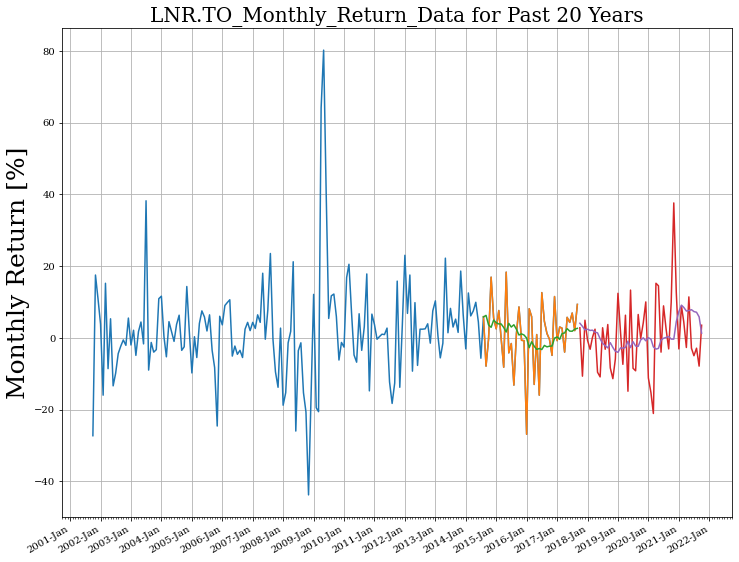

In [151]:
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
# ax.plot(x,y)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Monthly Return [%]',fontsize=25)\

ax.plot(full_train[col_name])
ax.plot(valid[[col_name, 'Predictions']])
ax.plot(test[[col_name, 'Predictions']])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.title(col_name+"_Data for Past 20 Years",fontsize=20)
# ax.set_title(col_name+"_Data for Past 20 Years", loc='left', y=0.95, x=0.02,
#              fontsize=20)
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

#2. Try Fama-French Linear Regression



In [424]:
df = pd.read_csv('fama-french-shifted.csv')
df.index = df['Date']
col_names = list(df.columns)
df = df.iloc[: , :-1]
df.head()

,Date,LNR.TO_Monthly_Return,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,,,
01/10/2021,01/10/2021,3.50,3.50,-9.95,7.02,8.05,2.46,5.28,-7.66,-3.01,-4.55
01/09/2021,01/09/2021,-7.99,3.50,-9.95,7.02,8.05,2.46,5.28,-7.66,-3.01,-4.55
01/08/2021,01/08/2021,-2.95,-7.99,-1.00,-4.65,-4.65,7.54,-0.31,2.22,-3.74,-1.66
01/07/2021,01/07/2021,-5.05,-2.95,0.72,2.98,-5.36,1.60,5.16,0.85,0.35,-0.28
01/06/2021,01/06/2021,-2.93,-5.05,-3.84,2.44,-9.51,-1.44,1.25,3.44,4.69,2.85


In [425]:
# change date to date and time
df['Date'] = pd.to_datetime(df.Date,format='%d/%m/%Y')
# change montly return to float
# df["LNR.TO_Monthly_Return"] = df["LNR.TO_Monthly_Return"].str.replace(r'.%$', '')
df["LNR.TO_Monthly_Return"] = pd.to_numeric(df["LNR.TO_Monthly_Return"])
print(df.dtypes)
# reverse the df frame to have the oldest data at the start
df = df.reindex(index=df.index[::-1])
df.head()

Date                     datetime64[ns]
LNR.TO_Monthly_Return           float64
IBM_Monthly_Return              float64
SPY_Monthly_Return              float64
MGA_Monthly_Return              float64
ABX.TO_Monthly_Return           float64
Mkt-RF                          float64
SMB                             float64
HML                             float64
RMW                             float64
CMA                             float64
dtype: object


,Date,LNR.TO_Monthly_Return,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,,,
01/10/2001,2001-10-01,-27.38,17.50,7.09,7.80,19.95,-4.37,1.25,5.09,-1.94,2.08
01/11/2001,2001-11-01,17.50,11.02,4.65,0.56,0.59,2.90,-0.79,-0.13,-0.25,-1.67
01/12/2001,2001-12-01,11.02,3.85,-10.81,-0.98,2.33,1.27,-4.56,-1.75,5.36,-0.55
01/01/2002,2002-01-01,3.85,-16.00,-8.93,-1.79,6.64,2.75,-0.25,-7.76,-2.14,-0.99
01/02/2002,2002-02-01,-16.00,15.22,5.99,3.33,6.65,0.29,1.19,7.04,2.34,3.10


Printout the training set

In [426]:
#split into train and validation
training_set_size = 192
testing_set_size = 48

train = df[:training_set_size]
valid = df[training_set_size:]



stock_name = "LNR.TO"
col_name = stock_name+"_Monthly_Return"

x_train = train.drop(col_name, axis=1)
x_train = x_train.drop("Date", axis=1)
y_train = train[col_name]
x_train.head()

,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,
01/10/2001,17.50,7.09,7.80,19.95,-4.37,1.25,5.09,-1.94,2.08
01/11/2001,11.02,4.65,0.56,0.59,2.90,-0.79,-0.13,-0.25,-1.67
01/12/2001,3.85,-10.81,-0.98,2.33,1.27,-4.56,-1.75,5.36,-0.55
01/01/2002,-16.00,-8.93,-1.79,6.64,2.75,-0.25,-7.76,-2.14,-0.99
01/02/2002,15.22,5.99,3.33,6.65,0.29,1.19,7.04,2.34,3.10


Print out the testing set

In [427]:

x_valid = valid.drop(col_name, axis=1)
x_valid = x_valid.drop("Date", axis=1)
y_valid = valid[col_name]
x_valid.head()

,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,
01/10/2017,-10.74,0.92,3.06,3.16,0.49,-0.36,0.69,0.27,-0.60
01/11/2017,4.96,-0.36,1.21,1.20,-1.22,-0.90,1.34,-2.11,0.36
01/12/2017,-0.79,6.70,5.64,0.85,3.92,2.79,-0.78,-1.23,-0.81
01/01/2018,-3.26,-3.89,-3.64,-3.81,0.57,3.28,2.81,0.96,-0.52
01/02/2018,0.17,-1.54,-2.73,3.11,3.65,2.79,-0.59,-0.95,0.29


In [428]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

In [429]:
#make predictions and find the rmse
preds = model.predict(x_valid)
RMSE=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print("The testing set error is RMSE = ", RMSE)

training_preds = model.predict(x_train)
RMSENew = np.sqrt(np.mean(np.power((np.array(y_train)-np.array(training_preds)),2)))
print("The training set error is RMSE = ", RMSENew)

The testing set error is RMSE =  11.422700755058097
The training set error is RMSE =  12.41523514263853


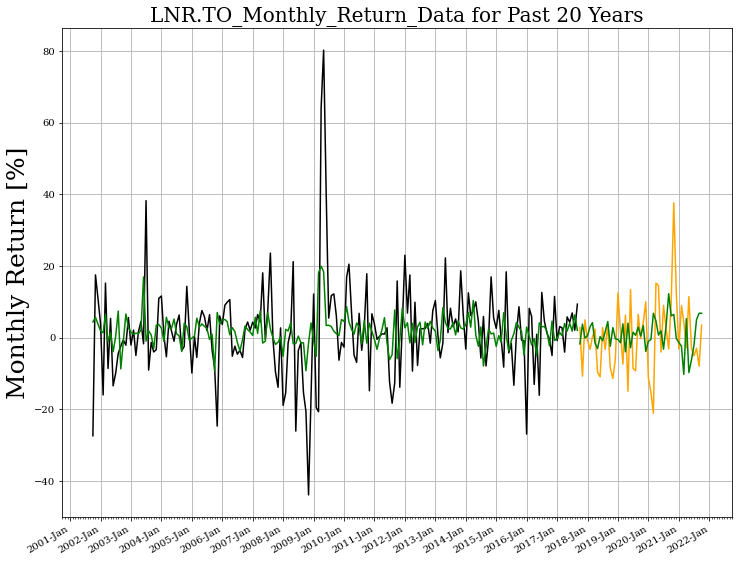

In [430]:
train_for_plot = df[:training_set_size][['Date', col_name]]
validation_for_plot = df[training_set_size:][["Date",col_name]]
train_for_plot.index = train_for_plot['Date']
validation_for_plot.index = validation_for_plot['Date']

# append the preds data for validation
validation_for_plot.loc[:,"Predictions"]=preds
# append the preds data for training set
train_for_plot.loc[:,"Predictions"]=training_preds

tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
# ax.plot(x,y)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(r'Monthly Return [%]',fontsize=25)

lines = ax.plot(train_for_plot[[col_name,"Predictions"]])
lines[0].set_color("black")
lines[1].set_color("green")
lines = ax.plot(validation_for_plot[[col_name, 'Predictions']])
lines[0].set_color("orange")
lines[1].set_color("green")
# ax.plot(test[[col_name, 'Predictions']])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.title(col_name+"_Data for Past 20 Years",fontsize=20)
# ax.set_title(col_name+"_Data for Past 20 Years", loc='left', y=0.95, x=0.02,
#              fontsize=20)
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

In [444]:
# test for the accuracy
from sklearn.metrics import accuracy_score
y_pred = []
for value in model.predict(x_valid):
  if value >=0:
    y_pred.append("Long")
  else:
    y_pred.append("Short")
y_true = []
for value in y_valid:
  if value >=0:
    y_true.append("Long")
  else:
    y_true.append("Short")
# print(y_true)
# print(y_pred)
result = accuracy_score(y_true, y_pred)
print("The accuracy for making prediction of LNR.TO direciton is only", result)

The accuracy for making prediction of LNR.TO direciton is only 0.3673469387755102


In [323]:
train_for_plot = df[:training_set_size][[col_name,"Mkt-RF","ABX.TO_Monthly_Return"]]
train_for_plot.head()

,LNR.TO_Monthly_Return,Mkt-RF,ABX.TO_Monthly_Return
Date,,,
01/10/2001,-27.38,-4.37,19.95
01/11/2001,17.50,2.90,0.59
01/12/2001,11.02,1.27,2.33
01/01/2002,3.85,2.75,6.64
01/02/2002,-16.00,0.29,6.65


Print out the Correlation Matrix

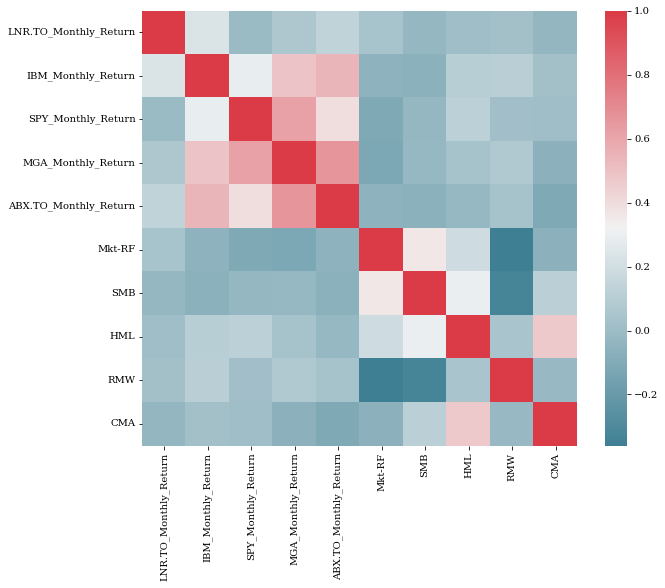

In [324]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Let's do a PCA anaylysis here

Text(0.5, 1.0, '2-dimensional dataset with principal components')

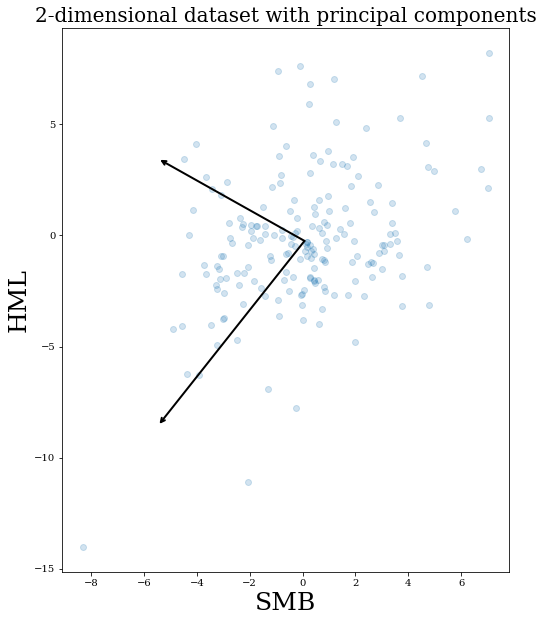

In [325]:
first_feature = "SMB"
second_feature = "HML"
# LNR.TO_Monthly_Return	IBM_Monthly_Return	SPY_Monthly_Return	MGA_Monthly_Return	ABX.TO_Monthly_Return	Mkt-RF	SMB	HML	RMW	CMA	RF

X = df[:training_set_size][[first_feature,second_feature]]
X.head()
X = X.to_numpy()

X.shape
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)


plt.gca().set(
    # aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel=first_feature,
    ylabel=second_feature,
)
ax.set_ylabel(second_feature,fontsize=25)
ax.set_xlabel(first_feature,fontsize=25)
plt.title("2-dimensional dataset with principal components",fontsize=20)

Text(0.5, 1.0, '2-dimensional dataset with principal components')

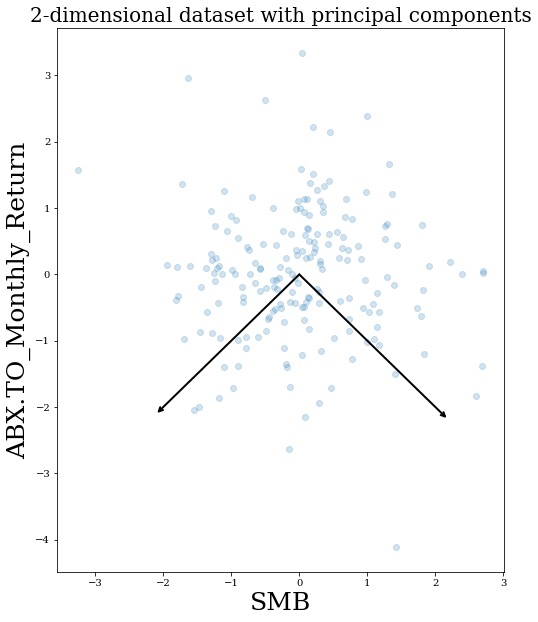

In [326]:
first_feature = "SMB"
second_feature = "ABX.TO_Monthly_Return"
# LNR.TO_Monthly_Return	IBM_Monthly_Return	SPY_Monthly_Return	MGA_Monthly_Return	ABX.TO_Monthly_Return	Mkt-RF	SMB	HML	RMW	CMA	RF
from sklearn.preprocessing import StandardScaler # normalize the dataset
scaler = StandardScaler()

X = df[:training_set_size][[first_feature,second_feature]]
X.head()
X = X.to_numpy()

scaler.fit(X)
X = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)


plt.gca().set(
    # aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel=first_feature,
    ylabel=second_feature,
)
ax.set_ylabel(second_feature,fontsize=25)
ax.set_xlabel(first_feature,fontsize=25)
plt.title("2-dimensional dataset with principal components",fontsize=20)

Text(0.5, 1.0, '2-dimensional dataset with principal components')

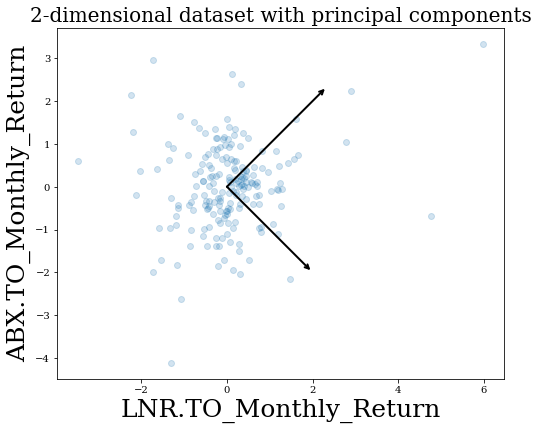

In [327]:
first_feature = "LNR.TO_Monthly_Return"
second_feature = "ABX.TO_Monthly_Return"
# LNR.TO_Monthly_Return	IBM_Monthly_Return	SPY_Monthly_Return	MGA_Monthly_Return	ABX.TO_Monthly_Return	Mkt-RF	SMB	HML	RMW	CMA	RF
from sklearn.preprocessing import StandardScaler # normalize the dataset
scaler = StandardScaler()

X = df[:training_set_size][[first_feature,second_feature]]
X.head()
X = X.to_numpy()

scaler.fit(X)
X = scaler.transform(X)

X.shape
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)


plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel=first_feature,
    ylabel=second_feature,
)
ax.set_ylabel(second_feature,fontsize=25)
ax.set_xlabel(first_feature,fontsize=25)
plt.title("2-dimensional dataset with principal components",fontsize=20)

Text(0.5, 1.0, '2-dimensional dataset with principal components')

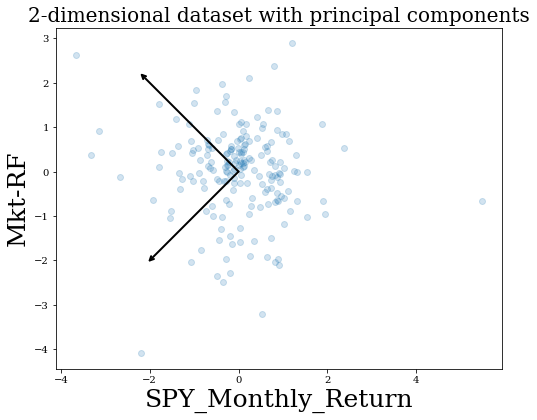

In [328]:
first_feature = "SPY_Monthly_Return"
second_feature = "Mkt-RF"
# LNR.TO_Monthly_Return	IBM_Monthly_Return	SPY_Monthly_Return	MGA_Monthly_Return	ABX.TO_Monthly_Return	Mkt-RF	SMB	HML	RMW	CMA	RF
from sklearn.preprocessing import StandardScaler # normalize the dataset
scaler = StandardScaler()

X = df[:training_set_size][[first_feature,second_feature]]
X.head()
X = X.to_numpy()

scaler.fit(X)
X = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)


plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel=first_feature,
    ylabel=second_feature,
)
ax.set_ylabel(second_feature,fontsize=25)
ax.set_xlabel(first_feature,fontsize=25)
plt.title("2-dimensional dataset with principal components",fontsize=20)

3. How about a decision Tree?

In [334]:
# import skr library to pre-processing the data
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df.head()

,Date,LNR.TO_Monthly_Return,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,,,
01/10/2001,2001-10-01,-27.38,17.50,7.09,7.80,19.95,-4.37,1.25,5.09,-1.94,2.08
01/11/2001,2001-11-01,17.50,11.02,4.65,0.56,0.59,2.90,-0.79,-0.13,-0.25,-1.67
01/12/2001,2001-12-01,11.02,3.85,-10.81,-0.98,2.33,1.27,-4.56,-1.75,5.36,-0.55
01/01/2002,2002-01-01,3.85,-16.00,-8.93,-1.79,6.64,2.75,-0.25,-7.76,-2.14,-0.99
01/02/2002,2002-02-01,-16.00,15.22,5.99,3.33,6.65,0.29,1.19,7.04,2.34,3.10


Change the regression result to classificaiton result

In [337]:
df.head()
heart_df = df.drop("Date", axis=1)
heartX = heart_df.iloc[:,1:]
hearty = heart_df.iloc[:,0] # seperate the output variable, the target column in the heart dataset
hearty = hearty.map(lambda x: "Long" if x>=0 else "Short")
hearty.head()

Date
01/10/2001    Short
01/11/2001     Long
01/12/2001     Long
01/01/2002     Long
01/02/2002    Short
Name: LNR.TO_Monthly_Return, dtype: object

split the train and test dataset

In [341]:
#split into train and validation
training_set_size = 192
testing_set_size = 48

stock_name = "LNR.TO"
col_name = stock_name+"_Monthly_Return"

heartX_train = heartX[:training_set_size]
hearty_train = hearty[:training_set_size]
heartX_train.head()

,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,
01/10/2001,17.50,7.09,7.80,19.95,-4.37,1.25,5.09,-1.94,2.08
01/11/2001,11.02,4.65,0.56,0.59,2.90,-0.79,-0.13,-0.25,-1.67
01/12/2001,3.85,-10.81,-0.98,2.33,1.27,-4.56,-1.75,5.36,-0.55
01/01/2002,-16.00,-8.93,-1.79,6.64,2.75,-0.25,-7.76,-2.14,-0.99
01/02/2002,15.22,5.99,3.33,6.65,0.29,1.19,7.04,2.34,3.10


In [342]:
heartX_test = heartX[training_set_size:]
hearty_test = hearty[training_set_size:]
heartX_test.head()

,IBM_Monthly_Return,SPY_Monthly_Return,MGA_Monthly_Return,ABX.TO_Monthly_Return,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,,,,,
01/10/2017,-10.74,0.92,3.06,3.16,0.49,-0.36,0.69,0.27,-0.60
01/11/2017,4.96,-0.36,1.21,1.20,-1.22,-0.90,1.34,-2.11,0.36
01/12/2017,-0.79,6.70,5.64,0.85,3.92,2.79,-0.78,-1.23,-0.81
01/01/2018,-3.26,-3.89,-3.64,-3.81,0.57,3.28,2.81,0.96,-0.52
01/02/2018,0.17,-1.54,-2.73,3.11,3.65,2.79,-0.59,-0.95,0.29


STEP-2 BUILD A DT WITH GINI Index

Build the decision tree with Gini index and print the generalization error rate in the tile of the plot.

Train accuracy is  0.9010416666666666
Test accuracy is  0.5102040816326531


Text(0.5, 0.98, 'Decision Tree based on Gini index\n The test accuracy is 51.02%')

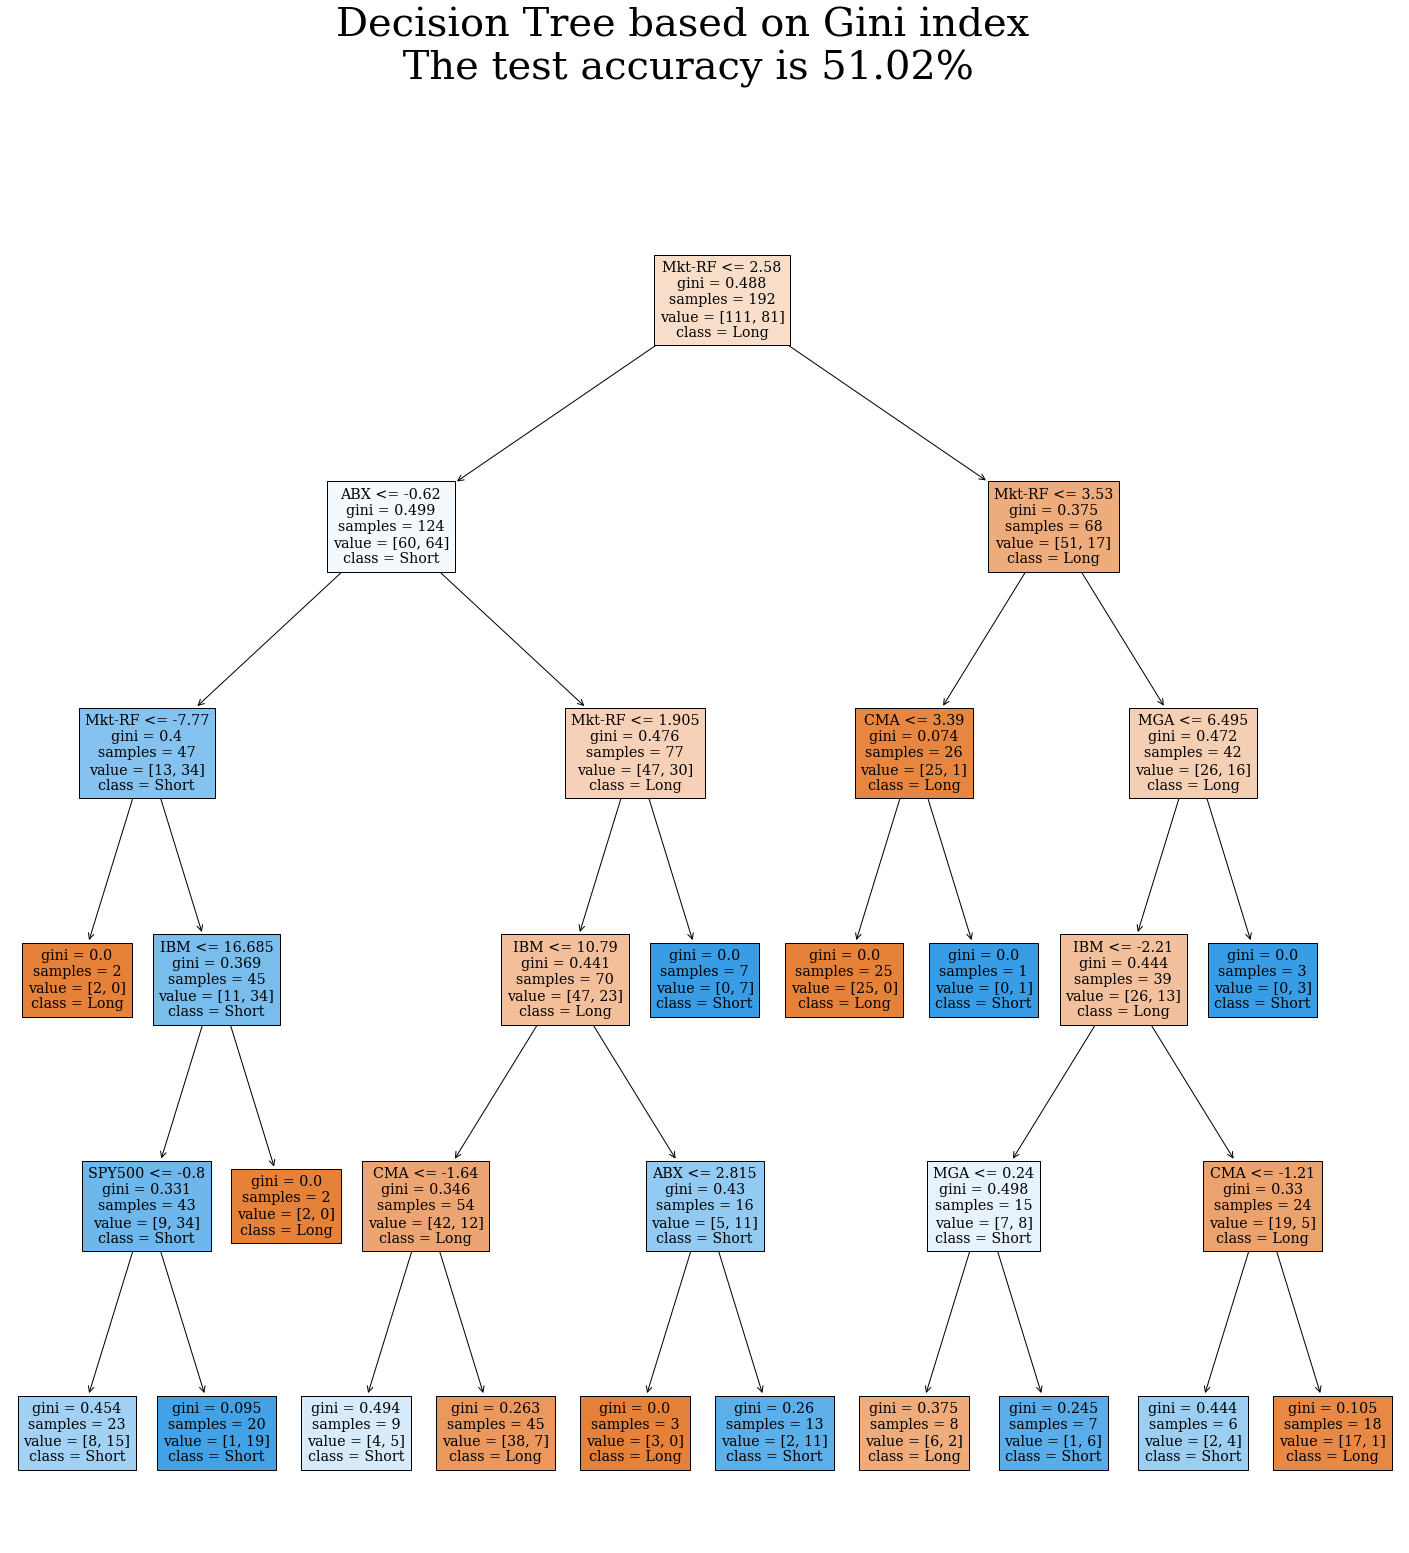

In [393]:
decisionTree_classifier = DecisionTreeClassifier(criterion='gini',splitter="best",max_depth=5)
decisionTree_classifier.fit(heartX_train, hearty_train)
decisionTree_accuracy = accuracy_score(hearty_test, decisionTree_classifier.predict(heartX_test))
training_accuracy = decisionTree_classifier.score(heartX_train, hearty_train)
print("Train accuracy is ",train_accuracy)
test_accuracy = model.score(heartX_test,hearty_test)
print("Test accuracy is ",test_accuracy)
fig = plt.figure(figsize=(25,25))
_ = tree.plot_tree(decisionTree_classifier,feature_names=["IBM","SPY500","MGA","ABX","Mkt-RF","SMB","HML","RMW","CMA"],class_names=["Long","Short"], filled=True)
fig.suptitle('Decision Tree based on Gini index\n The test accuracy is '+str((test_accuracy)*100)[:5]+"%", fontsize=40)

Try to build a random forest

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold

This function take a list of forest size, and return a list of [train accuracy, test accuracy] for each forest size

In [417]:
X = heartX_train
y = hearty_train
def plot_random_forest_accuracy_vs_tree_num(num_of_trees):
  train_accuracy_list = []
  test_accuracy_list = []
  for n in num_of_trees:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X,y)
    train_accuracy = model.score(X,y)
    test_accuracy = model.score(heartX_test,hearty_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
  
  return [train_accuracy_list,test_accuracy_list]

In [418]:
num_of_trees = [_ for _ in range(1,50)]
train_accuracy_list,test_accuracy_list = plot_random_forest_accuracy_vs_tree_num(num_of_trees)

Make the accuracy plot for the random forest

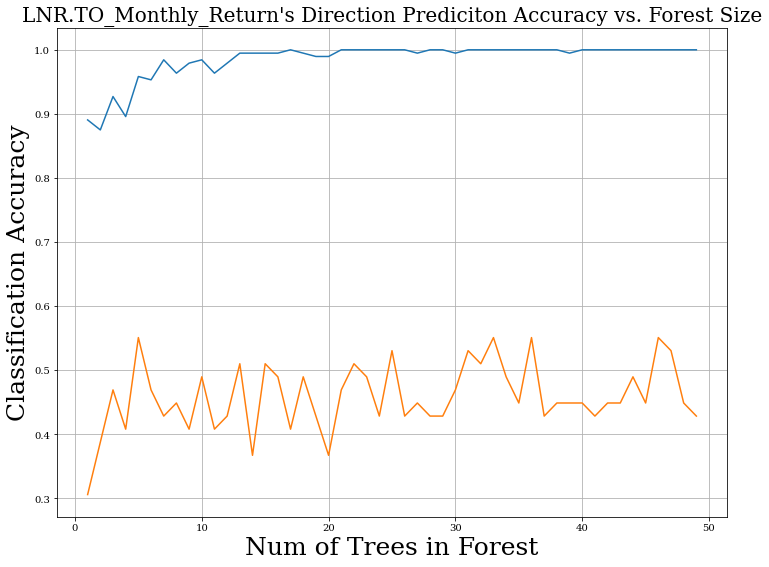

In [422]:
tick_spacing = 350
plt.rcParams.update({'font.family':'serif'})
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.grid(True)


ax.set_ylabel(r'Classification Accuracy',fontsize=25)
ax.set_xlabel(r'Num of Trees in Forest',fontsize=25)
line1 = ax.plot(num_of_trees,train_accuracy_list)
line2 = ax.plot(num_of_trees,test_accuracy_list)
plt.title(col_name+"'s Direction Prediciton Accuracy vs. Forest Size",fontsize=20)
plt.show()

In [401]:
outcome_var ='state'
# RandomForest
X = heartX_train
y = hearty_train
model = RandomForestClassifier(n_estimators=10)
model.fit(X,y)
predictions = model.predict(X)
accuracy = metrics.accuracy_score(predictions, y) # best performance is 1
print('Accuracy for training set:{0}%'.format(accuracy))
train_accuracy = model.score(X,y)
print("Train accuracy is ",train_accuracy)
test_accuracy = model.score(heartX_test,hearty_test)
print("Test accuracy is ",test_accuracy)

Accuracy for training set:0.96875%
Train accuracy is  0.96875
Test accuracy is  0.4897959183673469
